In [2]:
import turbo as tb
import rul_dataframe as rd
import plots as pl
import labeling as lb
import preprocessing as pre
import classification as cls
import variational_autoencoder as vae_class

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
dataset = 1
tr, te, rl = tb.getTFDataset(set = dataset)
tb.addTFlinear(tr, te, rl)
tr_df = rd.RUL_DataFrame(df = tr, label_cols = ['linear'])
te_df = rd.RUL_DataFrame(df = te, label_cols = ['linear'])

In [5]:
preproc = pre.Preprocessing()
classy = cls.Classification()
label = lb.Labeling()
# plots = pl.Plots(tr_df)

In [6]:
# preprocessing
if dataset in [1,3]:
    preproc.drop_zero_variance(tr_df)
    preproc.scale(tr_df, scale = 'std')
elif dataset in [2, 4]:
    classy.fit_kmeans(tr_df, colname = 'kmeans')
    preproc.one_hot_encode(tr_df, c_col = 'kmeans')
    preproc.c_drop_zero_variance(rul_df = tr_df , c_cols = tr_df.categ_cols)
    preproc.c_scale(rul_df = tr_df , c_cols = tr_df.categ_cols, scale = 'std')
preproc.moving_average(tr_df, shift = 10)

In [8]:
labels = pd.DataFrame(tr_df.df['linear'], columns=['linear'])

In [10]:
scale_optimized = pd.read_csv(f'fault_steps/FD00{dataset}')['Scale'].values

In [12]:
scale_optimized.mean()

148.41767068273091

In [13]:
dataset

4

In [13]:
label.piecewise_optimized(tr_df, scale_optimized)

In [16]:
labels['sadsad'] = tr_df.df['piecewise_optimized']

In [17]:
labels

,linear,sadsad
0,191,137
1,190,137
2,189,137
3,188,137
4,187,137
...,...,...
20626,4,4
20627,3,3
20628,2,2
20629,1,1


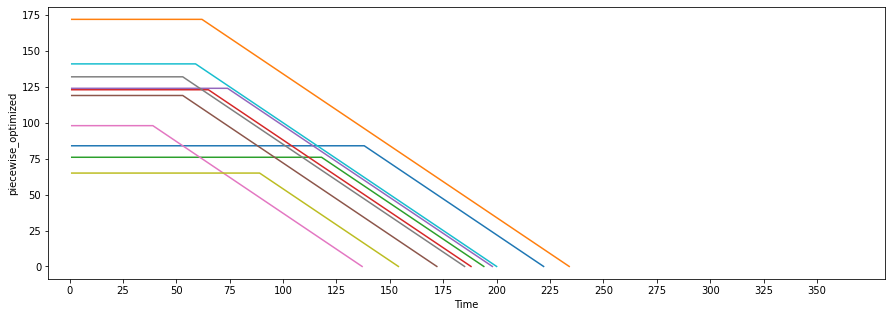

In [15]:
plots.timeplot_column('piecewise_optimized')

In [4]:
path = f'labels/FD00{dataset}'
labels = pd.DataFrame()

In [ ]:
# options for
# piecewise
max_rul = 125

# descriptive
if dataset in [1, 2]:
    cols = ['s2','s3','s4','s7','s12','s15']
elif dataset in [3, 4]:
    cols = ['s2','s3','s4','s11','s17']

# spearman
min_c = 0.7

# re and scaling from fault steps
scale = 'std'
normal_operation = 0.25
if dataset == 1:
    window_size = 0.05
    threshold = 1.15
elif dataset in [2, 4]:
    window_size = 0.1
    threshold = 1.5
elif dataset == 3:
    window_size = 0.05
    threshold = 1.5

In [7]:
for dataset in [1,2,3,4]:

    tr, te, rl = tb.getTFDataset(set = dataset)
    tb.addTFlinear(tr, te, rl)
    tr_df = rd.RUL_DataFrame(df = tr, label_cols = ['linear'])
    if dataset in [1,3]:
        preproc.drop_zero_variance(tr_df)
        preproc.scale(tr_df, scale = 'std')
    elif dataset in [2, 4]:
        classy.fit_kmeans(tr_df, colname = 'kmeans')
        preproc.one_hot_encode(tr_df, c_col = 'kmeans')
        preproc.c_drop_zero_variance(rul_df = tr_df , c_cols = tr_df.categ_cols)
        preproc.c_scale(rul_df = tr_df , c_cols = tr_df.categ_cols, scale = 'std')
    preproc.moving_average(tr_df, shift = 10)

    # get fault step based scaling
    scale_optimized = pd.read_csv(f'fault_steps/FD00{dataset}')['Scale'].values
    scale_optimized = label.set_min_scale(scale_optimized)

    # optimized piecewiese
    label.piecewise_optimized(tr_df, optimized_max_rul = scale_optimized)
    labels = pd.DataFrame(tr_df.df['piecewise_optimized'], columns=['piecewise_optimized'])

    # options for
    # piecewise
    max_ruls = [125]
    for m in max_ruls:
        label.piecewise(tr_df, max_rul = m)
        labels[f'piecewise_{m}'] = tr_df.df['piecewise']

    # descriptive
    if dataset in [1, 2]:
        cols = ['s2','s3','s4','s7','s12','s15']
    elif dataset in [3, 4]:
        cols = ['s2','s3','s4','s11','s17']
    label.descriptive(tr_df, cols = cols)
    preproc.scale_1_0(tr_df, 'descriptive')
    preproc.poly_fit(tr_df, col = 'descriptive', deg = 2)
    preproc.scale_1_0(tr_df, 'descriptive')
    label.scale_optimized(tr_df, col = 'descriptive', optimized_max_rul = scale_optimized)
    labels['descriptive'] = tr_df.df['descriptive_scaled']

    # spearman
    min_c = 0.7
    label.spearman(tr_df, min_c = min_c)
    preproc.poly_fit(tr_df, col = 'spearman', deg = 3)
    preproc.scale_1_0(tr_df, 'spearman')
    label.scale_optimized(tr_df, col = 'spearman', optimized_max_rul = scale_optimized)
    labels['spearman'] = tr_df.df['spearman_scaled']

    # reconstruction error
    re_raw = pd.read_csv(f'reconstruction_errors/FD00{dataset}')
    if dataset == 1:
        re_raw = re_raw.drop(re_raw.groupby(tr_df.id_col).head(9).index, axis=0).reset_index(drop = True)
    else:
        re_raw = re_raw.drop(re_raw.groupby(tr_df.id_col).head(5).index, axis=0).reset_index(drop = True)
    tr_df.df['rec_error'] = re_raw['rec_error']
    tr_df.label_cols.append('rec_error')
    preproc.moving_average(tr_df, cols = ['rec_error'], shift = 10, mp = 1)
    preproc.moving_average(tr_df, cols = ['rec_error'], shift = 10, mp = 1)
    preproc.scale_1_0(tr_df, 'rec_error')
    label.scale_optimized(tr_df, col = 'rec_error', optimized_max_rul = scale_optimized)
    labels['rec_error'] = tr_df.df['rec_error_scaled']

    path = f'labels/FD00{dataset}'
    labels.to_csv(path, index = False)

In [120]:
re_raw = re_raw.drop(re_raw.groupby(tr_df.id_col).head(5).index, axis=0)

In [1]:
# plots
labels = pd.read_csv(f'labels/FD00{4}')
tr, te, rl = tb.getTFDataset(set = 4)
tb.addTFlinear(tr, te, rl)
tr_df = rd.RUL_DataFrame(df = tr, label_cols = ['linear'])

NameError: name 'pd' is not defined

In [128]:
tr_df.df['rec_error'] = re_raw['rec_error']

In [129]:
tr_df.df['rec_error']

0       -0.004061
1       -0.000934
2        0.002659
3        0.010780
4        0.020442
           ...   
19726    0.167900
19727    0.081917
19728    0.170641
19729    0.306976
19730    0.202197
Name: rec_error, Length: 19731, dtype: float64

# Plots

In [6]:
dataset = 4
tr, te, rl = tb.getTFDataset(set = dataset)
tb.addTFlinear(tr, te, rl)
tr_df = rd.RUL_DataFrame(df = tr, label_cols = ['linear'])
preproc.moving_average(tr_df, shift = 10)
labels = pd.read_csv(f'labels/FD00{dataset}')
temp = pd.concat([tr_df.df, labels], axis=1)
tr_df_plots = rd.RUL_DataFrame(df = temp, label_cols = ['linear', 'piecewise_optimized', 'piecewise_100', 'piecewise_110',
                                                        'piecewise_120', 'piecewise_130', 'descriptive', 'spearman',
                                                        'rec_error'])
plots = pl.Plots(tr_df_plots)

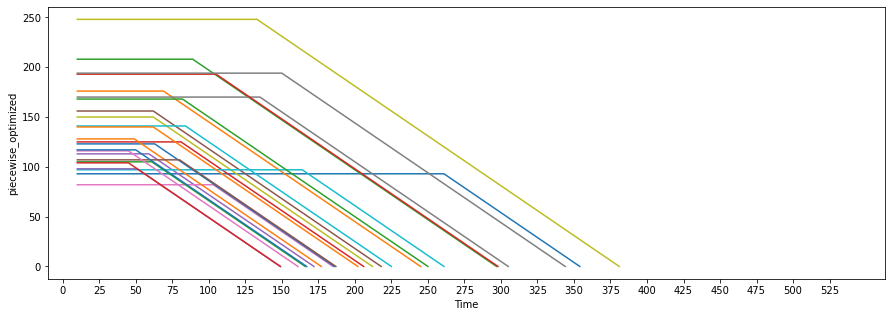

In [8]:
column_plot = 'piecewise_optimized'
plots.timeplot_column(column_plot)

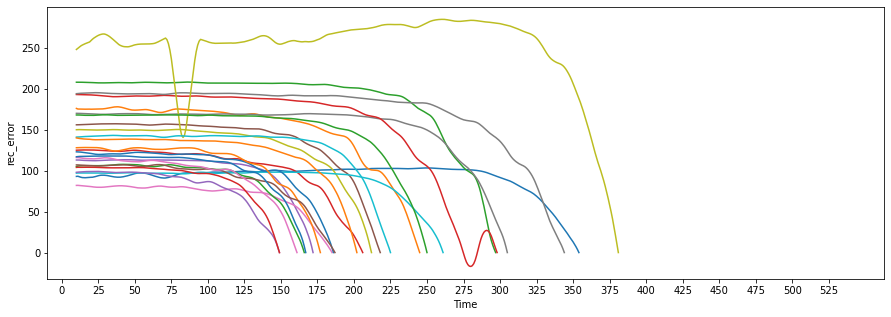

In [148]:
column_plot = 'rec_error'
plots.timeplot_column(column_plot)

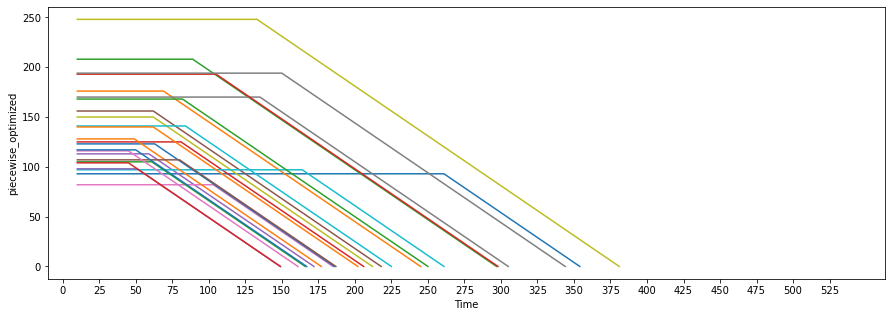

In [149]:
column_plot = 'piecewise_optimized'
plots.timeplot_column(column_plot)

# OLD CODE

## Clipped

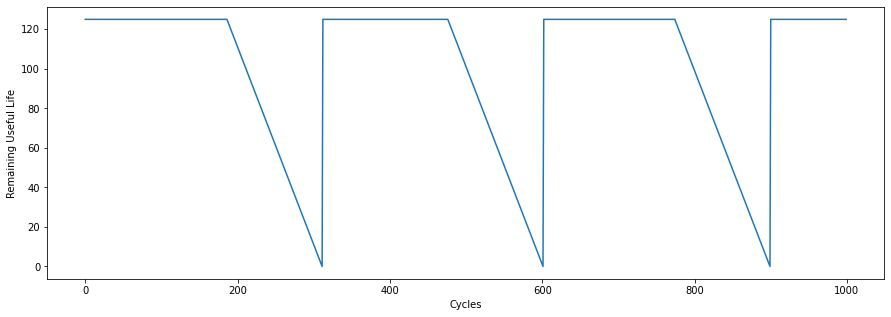

In [10]:
label.piecewise(tr_df)

plt.figure(figsize=(15,5))
plt.plot(range(1000), tr_df.df['piecewise'][0:1000])
plt.ylabel('Remaining Useful Life')
plt.xlabel('Cycles')
plt.show()

ValueError: Unrecognized character e in format string

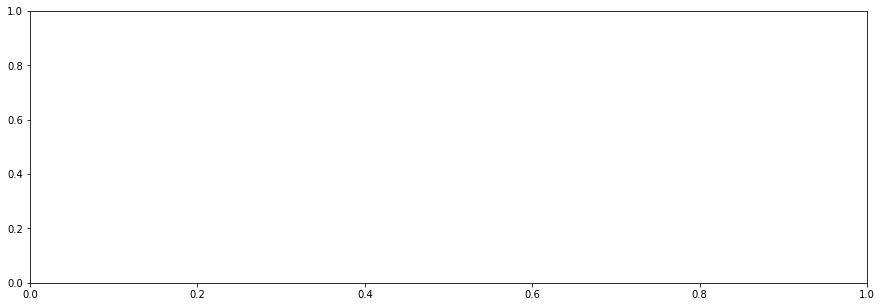

In [32]:
plots.timeplot_column('rec_error_scaled')

# Fault Step Detection

In [ ]:
label.piecewise_optimized(tr_df, optimized_max_rul = scale)
plots.timeplot_column('piecewise_optimized')

## Descriptive

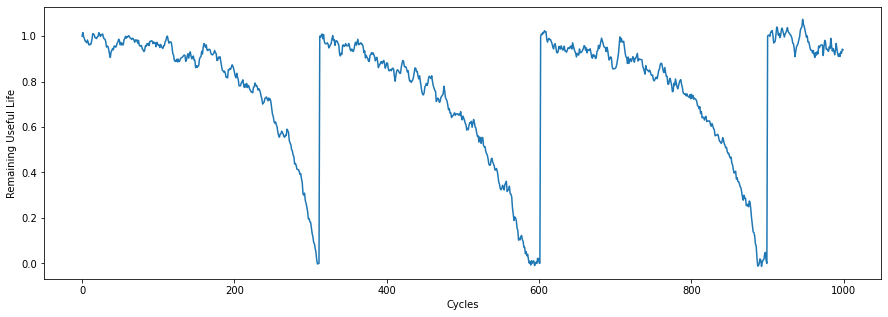

In [10]:
if dataset in [1, 2]:
    cols = ['s2','s3','s4','s7','s12','s15']
elif dataset in [3, 4]:
    cols = ['s2','s3','s4','s11','s17']

label.descriptive(tr_df, cols)

preproc.scale_1_0(tr_df, 'descriptive')

plt.figure(figsize=(15,5))
plt.plot(range(1000), tr_df.df['descriptive'][0:1000])
plt.ylabel('Remaining Useful Life')
plt.xlabel('Cycles')
plt.show()

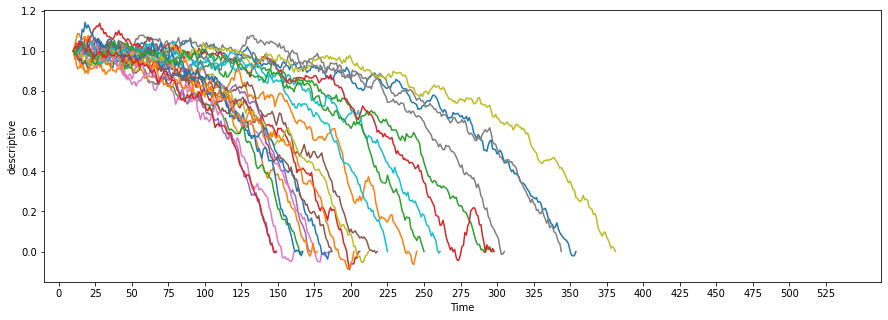

In [22]:
plots.timeplot_column('descriptive')

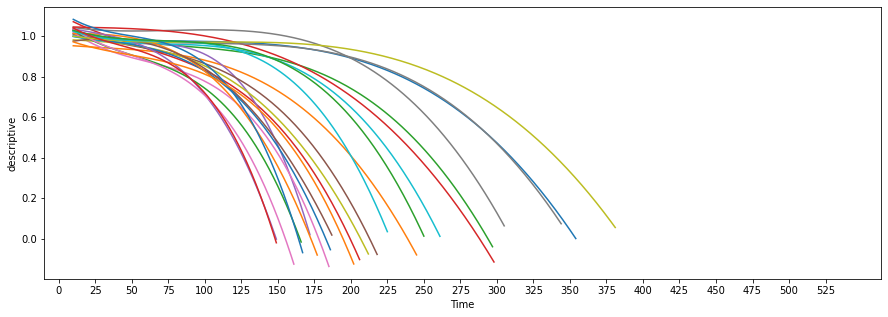

In [11]:
preproc.poly_fit(tr_df, 'descriptive', deg = 3)
plots.timeplot_column('descriptive')

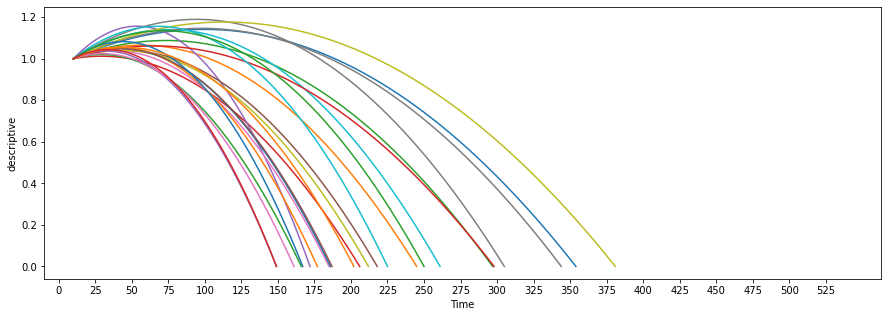

In [9]:
preproc.scale_1_0(tr_df, 'descriptive')
plots.timeplot_column('descriptive')

## Correlation Based

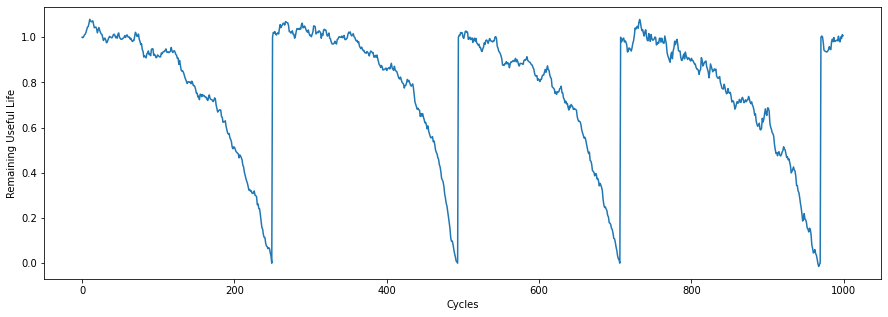

In [13]:
if dataset in [1,4]:
    min_c = 0.7
elif dataset == 2:
    min_c = 0.7
min_c = 0.7
label.spearman(tr_df, min_c = min_c)

preproc.scale_1_0(tr_df, 'spearman')

plt.figure(figsize=(15,5))
plt.plot(range(1000), tr_df.df['spearman'][0:1000])
plt.ylabel('Remaining Useful Life')
plt.xlabel('Cycles')
plt.show()

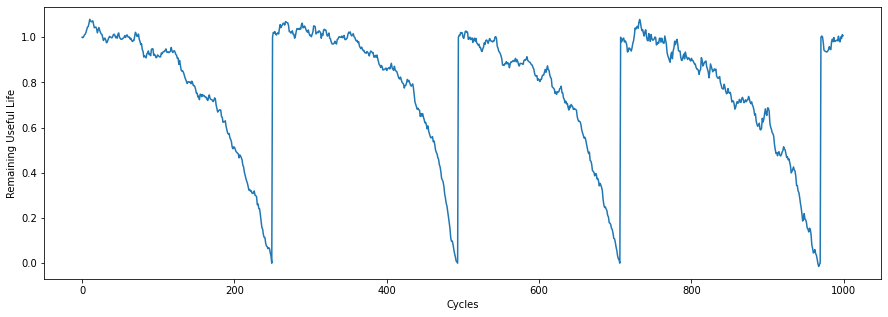

In [16]:
if dataset == 1:
    min_c = 0.7
elif dataset == 4:
    min_c = 0.5
min_c = 0.5
label.kendall(tr_df, min_c = min_c)

preproc.scale_1_0(tr_df, 'kendall')

plt.figure(figsize=(15,5))
plt.plot(range(1000), tr_df.df['kendall'][0:1000])
plt.ylabel('Remaining Useful Life')
plt.xlabel('Cycles')
plt.show()

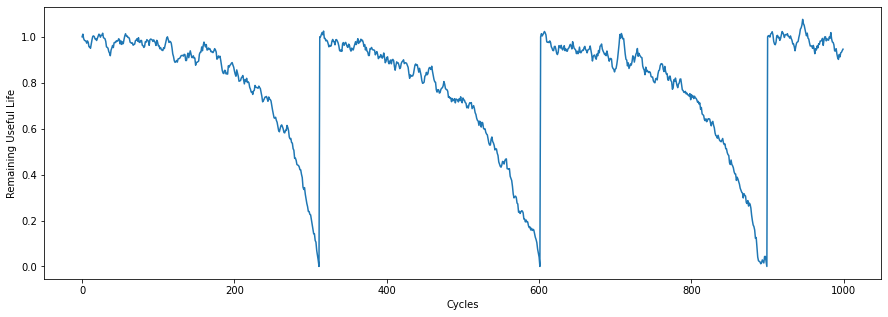

In [14]:
if dataset in [1, 4]:
    min_c = 0.7
elif dataset == 2:
    min_c = 0.7

label.pearson(tr_df, min_c = min_c)

preproc.scale_1_0(tr_df, 'pearson')

plt.figure(figsize=(15,5))
plt.plot(range(1000), tr_df.df['pearson'][0:1000])
plt.ylabel('Remaining Useful Life')
plt.xlabel('Cycles')
plt.show()

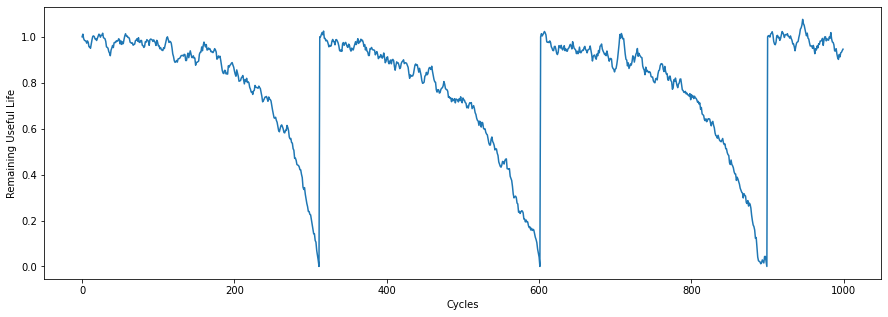

In [15]:
if dataset in [1, 4]:
    min_c = 0.7
elif dataset == 2:
    min_c = 0.7

label.distance(tr_df, min_c = min_c)
preproc.scale_1_0(tr_df, 'distance')

plt.figure(figsize=(15,5))
plt.plot(range(1000), tr_df.df['distance'][0:1000])
plt.ylabel('Remaining Useful Life')
plt.xlabel('Cycles')
plt.show()

## Autoencoder

In [8]:
# prepare data
normal_operation = 0.25
X = tr_df.df[[tr_df.id_col] + tr_df.data_cols].copy()
for i, d in X.groupby(tr_df.id_col):
    q25 = int(d.shape[0] * normal_operation) + 1
    X = X.drop(range(d.index[0] + q25, d.index[-1] + 1))
X = X.drop(columns = tr_df.id_col)
X = np.asarray(X, dtype=float)

In [9]:
XX = np.array(tr_df.df[tr_df.data_cols])

In [10]:
input_dim = len(tr_df.data_cols)

#### a. Vanilla Autoencoder

In [23]:
ae_vanilla = vae_class.Autoencoder(input_dim = input_dim)
ae_vanilla.compile(optimizer = 'Adam', loss = 'MSE')
ae_vanilla.fit(X, X, epochs = 20)
ae_vanilla.save_weights(f'saved_models/Autoencoder_FD00{dataset}_input_dim{input_dim}')

INFO:tensorflow:Assets written to: saved_models/Autoencoder_FD004_input_dim18\assets


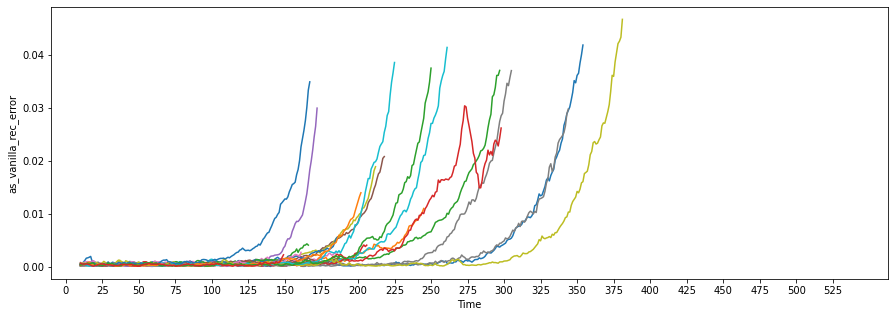

In [24]:
prediction = ae_vanilla.predict(XX)
reconstruction_error = tf.metrics.mean_squared_error(XX, prediction)
tr_df.df['as_vanilla_rec_error'] = reconstruction_error
tr_df.label_cols.append('as_vanilla_rec_error')
plots.timeplot_column('as_vanilla_rec_error')

#### b. Variational Autoencoder

In [11]:
vae_vanilla = vae_class.VariationalAutoencoderELBO_MSE_KL(input_dim = input_dim)
vae_vanilla.compile(optimizer = 'Adam')
vae_vanilla.fit(X, epochs = 20)
vae_vanilla.save_weights(f'saved_weights/VariationalAutoencoderELBO_MSE_KL_FD00{dataset}_input_dim{input_dim}_weights')

Epoch 1/20
157/157 [==============================] - 1s 2ms/step - loss: 0.1816 - mse loss: 0.1164 - kl div: 0.1615
Epoch 2/20
157/157 [==============================] - 0s 2ms/step - loss: 0.0292 - mse loss: 0.0276 - kl div: 0.0021
Epoch 3/20
157/157 [==============================] - 0s 2ms/step - loss: 0.0142 - mse loss: 0.0135 - kl div: 8.3485e-04
Epoch 4/20
157/157 [==============================] - 0s 2ms/step - loss: 0.0089 - mse loss: 0.0084 - kl div: 5.3233e-04
Epoch 5/20
157/157 [==============================] - 0s 2ms/step - loss: 0.0071 - mse loss: 0.0067 - kl div: 3.7307e-04
Epoch 6/20
157/157 [==============================] - 0s 2ms/step - loss: 0.0062 - mse loss: 0.0059 - kl div: 2.7532e-04
Epoch 7/20
157/157 [==============================] - 0s 2ms/step - loss: 0.0058 - mse loss: 0.0055 - kl div: 2.3316e-04
Epoch 8/20
157/157 [==============================] - 0s 2ms/step - loss: 0.0055 - mse loss: 0.0053 - kl div: 2.0171e-04
Epoch 9/20
157/157 [====================

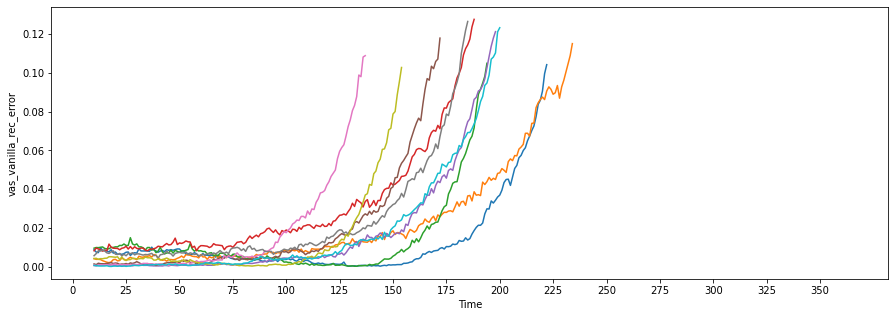

In [12]:
prediction = vae_vanilla.predict(XX)
reconstruction_error = tf.metrics.mean_squared_error(XX, prediction)
tr_df.df['vas_vanilla_rec_error'] = reconstruction_error
tr_df.label_cols.append('vas_vanilla_rec_error')
plots.timeplot_column('vas_vanilla_rec_error')